In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import seaborn as sns
from pathlib import Path

In [2]:
cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv")
cases.date = pd.to_datetime(cases.date)
cases = cases[(cases.county == "Harris") & (cases.state == "Texas")]
cases = cases.pivot(index="date", columns="fips", values="cases").diff().rolling(7).mean()
cases.columns = ["cases"]
# cases

In [3]:
uncert = pd.concat(map(pd.read_csv, glob("../data/Houston_output/window_5_step_5/*/uncert.csv")))
uncert["date"] = pd.to_datetime(uncert.graph_name.apply(lambda row: row.split("_")[0]))
# uncert["end"] = pd.to_datetime(uncert.graph_name.apply(lambda row: row.split("_")[-1]))
uncert = uncert.set_index("date").drop(columns=["graph_name"])
uncert = uncert.reindex(pd.date_range(uncert.index.min(), uncert.index.max(), freq=f"{5}D"))
uncert = uncert.fillna(0)
uncert = uncert.reindex(cases.index)
uncert = uncert.fillna(method="ffill")
uncert = uncert.replace(0, np.nan)

uncert.columns = ["full_none", "full_genomes", "full_seqs", "full_genomes+seqs", "collapsed_none", "collapsed_genomes", "collapsed_seqs", "collapsed_genomes+seqs"]

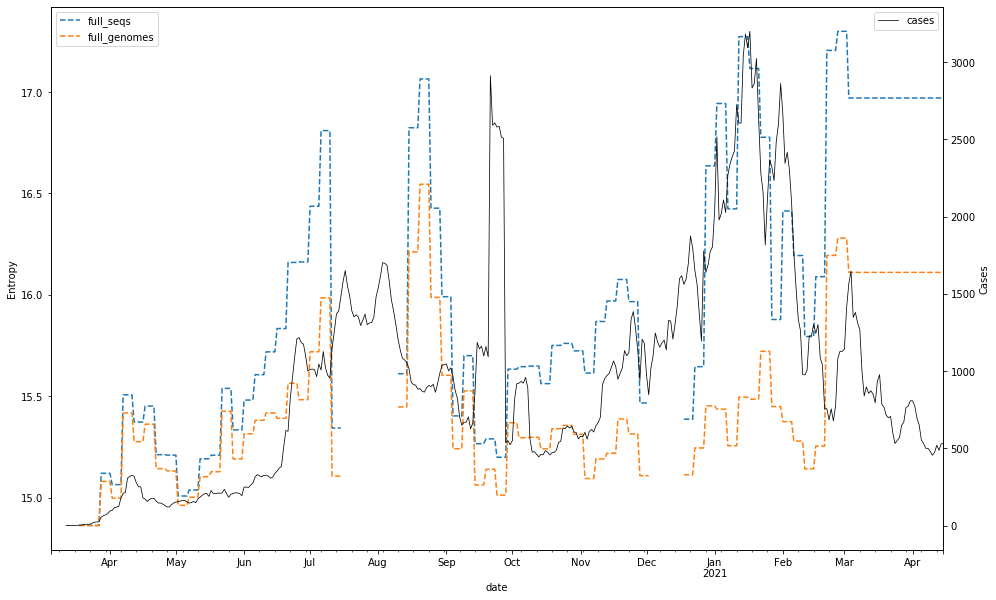

In [24]:
uncert_full = uncert[["full_seqs", "full_genomes"]]

fig, ax = plt.subplots(figsize=(16,10))

twinx = ax.twinx()

uncert_full.plot(ax=ax, linestyle="--")
cases.plot(ax=twinx, color="k", linewidth=0.75)

ax.set_ylabel("Entropy")
twinx.set_ylabel("Cases")
plt.savefig("full_seqs_houston_5_days.png")

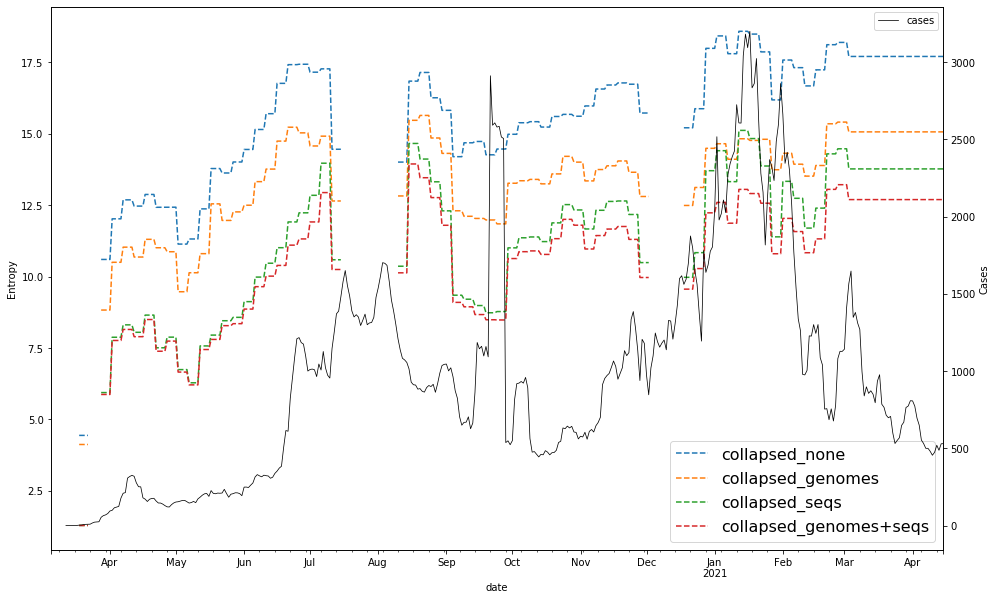

In [26]:
uncert_collapsed = uncert[[c for c in uncert.columns if "collapsed" in c]]

fig, ax = plt.subplots(figsize=(16,10))

twinx = ax.twinx()

uncert_collapsed.plot(ax=ax, linestyle="--")
cases.plot(ax=twinx, color="k", linewidth=0.75)

ax.set_ylabel("Entropy")
twinx.set_ylabel("Cases")
ax.legend(fontsize=16)
plt.savefig("collapsed_seqs_houston_5_days.png", dpi=100)

In [36]:
data_loc = "New_York_City"

location_data = glob(f"../data/{data_loc}_output/window_7_step_7/*/uncert.csv") +  glob(f"../data/output/{data_loc}/window_7_step_7/*/uncert.csv")
uncerts = []
for path in location_data:
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df.graph_name.apply(lambda row: row.split("_")[0]))
    uncerts.append(df)

uncert = pd.concat(uncerts)
uncert = uncert.groupby("date").max().drop(columns=["graph_name"]) #.dropna()
print(uncert.index)

if diff:
    uncert = uncert.diff()
uncert = uncert[[c for c in uncert.columns if c not in ["aa_full_sequences_1_genomes_1", "aa_full_sequences_0_genomes_0"]]]


if uncert.index.min() < cases.index.min():
    uncert = uncert.iloc[1:]
uncert_cases = cases.loc[uncert.index.min():] #.resample("7D").sum().diff()
uncert = uncert.reindex(uncert_cases.resample("7D").sum().index)
uncert = uncert.replace(0, -1)
uncert = uncert.fillna(0)
uncert = uncert.reindex(uncert_cases.index)
uncert = uncert.fillna(method="ffill")
uncert = uncert.replace(0, np.nan)
uncert = uncert.replace(-1, 0)
uncert.loc["2020-06-01":].head(30)

DatetimeIndex(['2020-03-02', '2020-03-09', '2020-03-16', '2020-03-23',
               '2020-03-30', '2020-04-06', '2020-04-13', '2020-04-20',
               '2020-04-27', '2020-05-04', '2020-05-11', '2020-06-08',
               '2020-06-29', '2020-07-06', '2020-07-13', '2020-07-27',
               '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24',
               '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21',
               '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19',
               '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
               '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-21',
               '2020-12-28', '2021-01-11', '2021-01-18', '2021-01-25',
               '2021-02-01', '2021-02-08', '2021-02-15', '2021-02-22',
               '2021-03-01', '2021-03-08', '2021-03-15', '2021-03-29'],
              dtype='datetime64[ns]', name='date', freq=None)


,full_sequences_0_genomes_1,full_sequences_1_genomes_0,collapsed_sequences_0_genomes_0,collapsed_sequences_0_genomes_1,collapsed_sequences_1_genomes_0,collapsed_sequences_1_genomes_1,aa_full_sequences_0_genomes_1,aa_full_sequences_1_genomes_0,aa_collapsed_sequences_0_genomes_0,aa_collapsed_sequences_0_genomes_1,aa_collapsed_sequences_1_genomes_0,aa_collapsed_sequences_1_genomes_1
date,,,,,,,,,,,,
2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-08,14.861959,14.861959,0.000000,0.000000,0.000000,0.000000,13.252665,13.252665,0.000000,0.000000,0.00000,0.000000
2020-06-09,14.861959,14.861959,0.000000,0.000000,0.000000,0.000000,13.252665,13.252665,0.000000,0.000000,0.00000,0.000000


In [12]:
import pickle
loc_date_samples = pickle.load(open("loc_date_samples.pkl", "rb"))

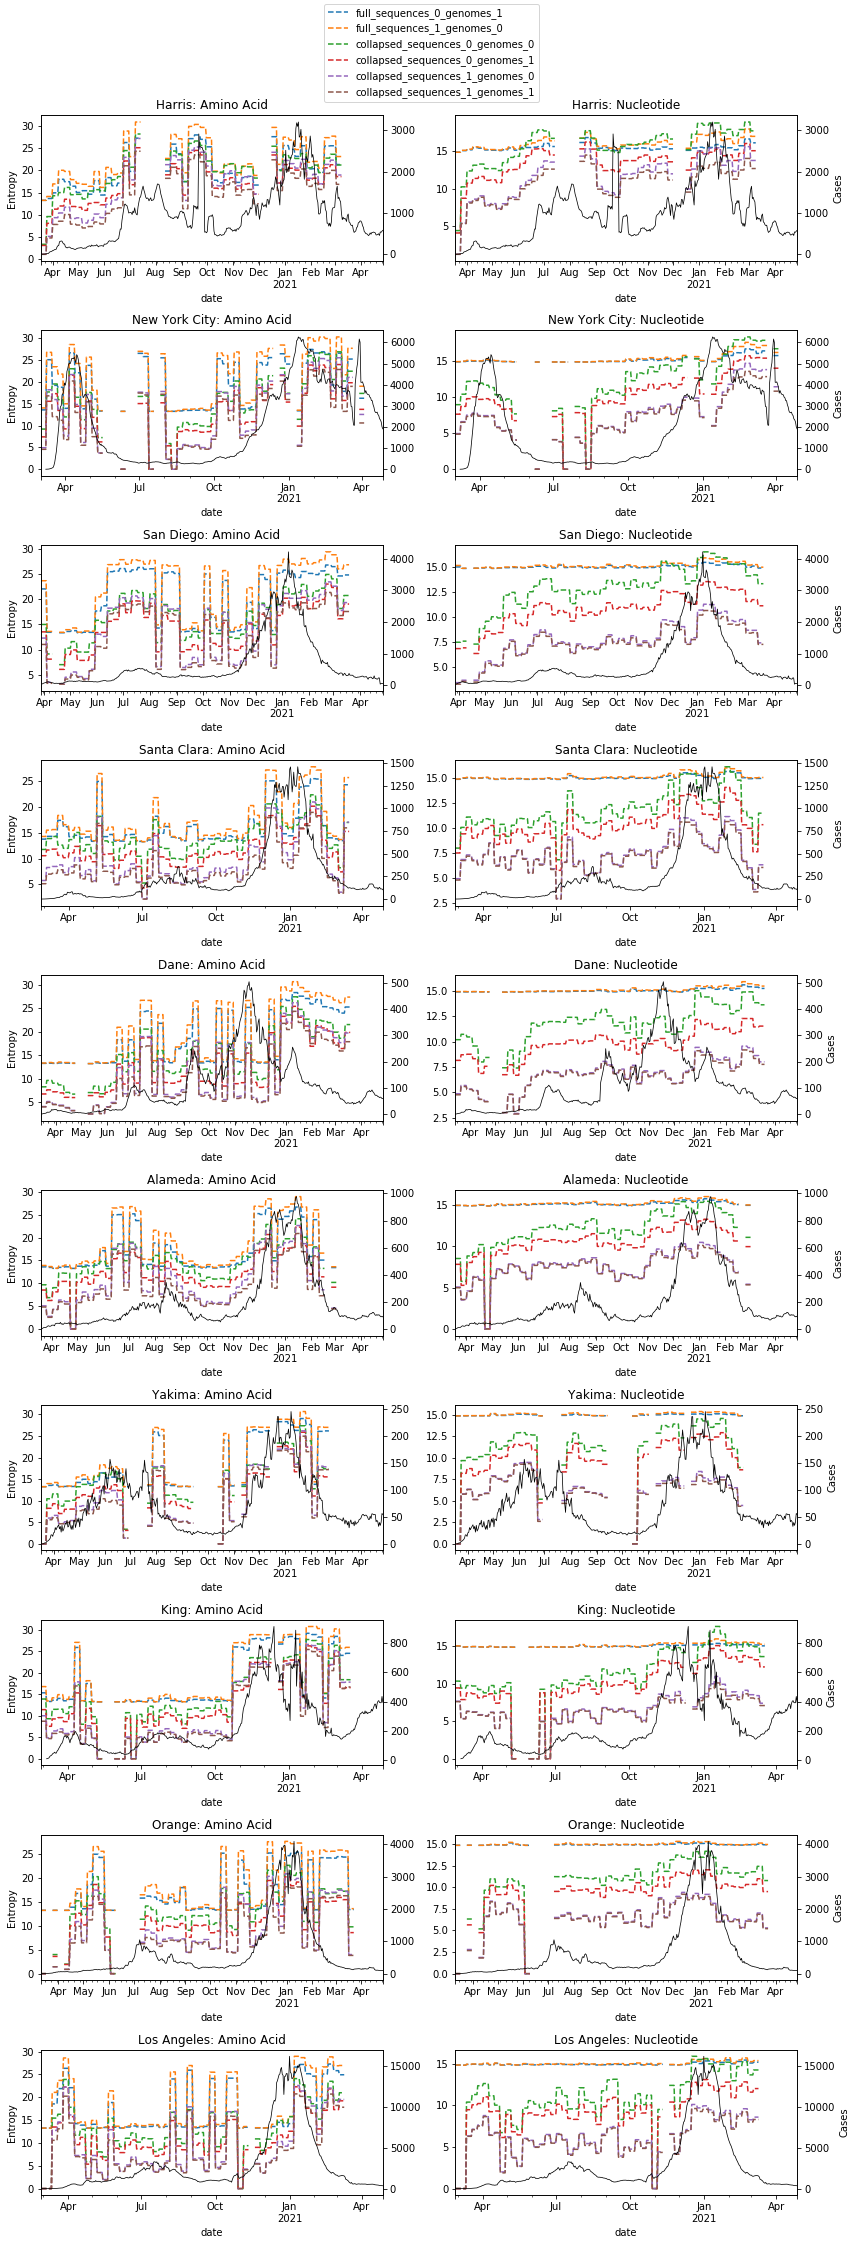

In [37]:
nyt_cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv")
nyt_cases.date = pd.to_datetime(nyt_cases.date)

rolling=True
diff=False

fig, axs = plt.subplots(10,2, figsize=(12,30))

locations = [('Texas', 'Harris', "Houston"),
             ('New York', 'New York City', "New_York_City"),
             ('California', 'San Diego', "San_Diego"),
             ('California', 'Santa Clara', "Santa_Clara_County"),
             ('Wisconsin', 'Dane', "Dane_County"),
             ('California', 'Alameda', "Alameda_County"),
             ('Washington', 'Yakima', "Yakima_County"),
             ('Washington', 'King', "King_County"),
             ('California', 'Orange', "Orange_County"),
             ('California', 'Los Angeles', "Los_Angeles_County")]

ix = 0
for state, location, data_loc in locations:
    ax1 = axs[ix,0]
    ax2 = axs[ix,1]
    cases = nyt_cases[(nyt_cases.state == state) & (nyt_cases.county == location)]
    cases = cases.pivot(index="date", columns="fips", values="cases")
    cases = cases.diff()
    if rolling:
        cases = cases.rolling(7).mean() #Should I take the mean here?
    cases.columns = ["cases"]
    
    location_data = glob(f"../data/{data_loc}_output/window_7_step_7/*/uncert.csv") +  glob(f"../data/output/{data_loc}/window_7_step_7/*/uncert.csv")
    uncerts = []
    for path in location_data:
        df = pd.read_csv(path)
        df["date"] = pd.to_datetime(df.graph_name.apply(lambda row: row.split("_")[0]))
        uncerts.append(df)

    uncert = pd.concat(uncerts)
    uncert = uncert.groupby("date").max().drop(columns=["graph_name"]) #.dropna()
    if diff:
        uncert = uncert.diff()
    uncert = uncert[[c for c in uncert.columns if c not in ["aa_full_sequences_1_genomes_1", "aa_full_sequences_0_genomes_0"]]]
    
    if uncert.index.min() < cases.index.min():
        uncert = uncert.iloc[1:]
    uncert_cases = cases.loc[uncert.index.min():] #.resample("7D").sum().diff()
    uncert = uncert.reindex(uncert_cases.resample("7D").sum().index)
    uncert = uncert.replace(0, -1)
    uncert = uncert.fillna(0)
    uncert = uncert.reindex(uncert_cases.index)
    uncert = uncert.fillna(method="ffill")
    uncert = uncert.replace(0, np.nan)
    uncert = uncert.replace(-1, 0)

#     if uncert.index.min() < cases.index.min():
#         uncert = uncert.iloc[1:]
#     uncert_cases = cases.loc[uncert.index.min():] #.resample("7D").sum().diff()
#     uncert = uncert.fillna(0)
#     uncert = uncert.reindex(uncert_cases.index)
#     uncert = uncert.fillna(method="ffill")
#     uncert = uncert.replace(0, np.nan)
    handles_labels = []
    for ax_ix, cur_ax in enumerate([ax1,ax2]):
        if ax_ix == 0:
            columns = [c for c in uncert.columns if "aa" in c]
        else:
            columns = [c for c in uncert.columns if not "aa" in c]
            
#         print(columns)
        twinx = cur_ax.twinx()

        uncert[columns].plot(ax=cur_ax, linestyle="--")
        uncert_cases.plot(ax=twinx, color="k", linewidth=0.75)
        
        if ax_ix == 0:
            cur_ax.set_ylabel("Entropy")
        else:
            twinx.set_ylabel("Cases")
            handles_labels.append(cur_ax.get_legend_handles_labels())
            
#         cur_ax.legend(fontsize=9)
        
        twinx.get_legend().remove()
        cur_ax.get_legend().remove()
        cur_ax.set_title(f"{location}: {'Amino Acid' if ax_ix == 0 else 'Nucleotide'}")
    
    ix += 1
#     break
# uncert
fig.legend(handles_labels[0][0], handles_labels[0][1], bbox_to_anchor=(0.63, 1.04))
plt.tight_layout()
plt.savefig("all_locations_entropy_and_cases_curves.png", dpi=100, bbox_inches="tight")